In [1]:
%load_ext autoreload
%autoreload 2
import torch as t
import cv2 
import sys
sys.path.append("/data_nfs/je30bery/melanoma_data/model")
from model import EfficientnetWithFinetuning
from data import MelanomaData
from scipy.stats import pearsonr
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, f1_score, accuracy_score
from sklearn.decomposition import PCA
import random 
import pandas as pd
import seaborn as sns
from tqdm.notebook import trange, tqdm
from sklearn.linear_model import LinearRegression
sys.path.append("../..")
os.environ["CUDA_VISIBLE_DEVICES"]="1"

os.getcwd()

'/data_nfs/je30bery/melanoma_data/model/features'

In [2]:
import MAGICAL as mg

In [3]:
markers = ['ADAM10', 'Bcl-2', 'CD10', 'CD107a', 'CD13', 'CD138', 'CD14', 'CD1a', 'CD2', 'CD25', 'CD271', 'CD3', 'CD36', 'CD4', 'CD44', 'CD45', 'CD45RA', 'CD45RO', 'CD5', 'CD56', 'CD6', 'CD63', 'CD66abce', 'CD7', 'CD71', 'CD8', 'CD9', 'CD95', 'Collagen IV', 'Cytokeratin-14', 'EBF-P', 'EGFR', 'EGFR-AF488', 'HLA-ABC', 'HLA-DR', 'KIP1', 'Ki67', 'L302', 'MCSP', 'Melan-A', 'Nestin-AF488', 'Notch-1', 'Notch-3', 'PPARgamma', 'PPB', 'RIM3', 'TAP73', 'Vimentin', 'p63', 'phospho-Connexin']    

In [4]:
base = "/data_nfs"
data = mg.get_data_csv(base)
dl = t.utils.data.DataLoader(MelanomaData(markers, dataset="Melanoma", data=data, mode="val"), batch_size=10) 
data['Ulcerated'].replace({False: -1, np.nan: 0, True: 1}, inplace=True)
data['Secondary'].replace({False: -1, np.nan: 0, True: 1}, inplace=True)
data['Nodular'].replace({False: -1, np.nan: 0, True: 1}, inplace=True)

In [5]:
labels = data["Group"]

In [6]:
def extract_features(model, x):
    model = model.cuda()
    x = x.cuda()
    x = model.features(x)
    x = model.avgpool(x)
    x = model.flatten(x)
    x = model.classifier1(x)    
    return x

In [7]:
try:
    features = np.load("features_regressor.npy")
except:
    model = EfficientnetWithFinetuning(indim=len(markers))
    model.load_state_dict(t.load("/data_nfs/je30bery/melanoma_data/model/training/saved_models/model_2023-11-20 16:27:56.558630_f1=0.9260606060606061_acc=0.9166666666666666_11.pt"))
    model.eval()
    it = iter(dl)
    features = list()
    while True:
        try:
            input_t, label = next(it)
        except StopIteration:
            break
        features.append(extract_features(model, input_t).detach().cpu().numpy())
    features = np.concatenate(features)
    np.save("features.npy", features)

In [8]:
#kmeans = KMeans(n_clusters=4, n_init="auto")
#y = kmeans.fit_predict(features)
#data["PC1"] = transf[:,0]
#data["PC2"] = transf[:,1]
#data["k=4 cluster"] = y

In [9]:
p = PCA(50)
transf = p.fit_transform(features)
pca = pd.DataFrame(transf)
pca.columns = [f"PC{c}" for c in pca.columns]

In [10]:
data['Sex'].replace({'f': -1, 'm': 1}, inplace=True)
data['Group'].replace({'Nevus': -1, 'Melanoma': 1}, inplace=True)
for c in ["Collection year", "Age", 'Sex', 'Float tumor stage']: #cols:
    data[c] = data[c].astype(float)
    pca[c] = (data[c] - data[c].mean()) / data[c].std()

<Axes: >

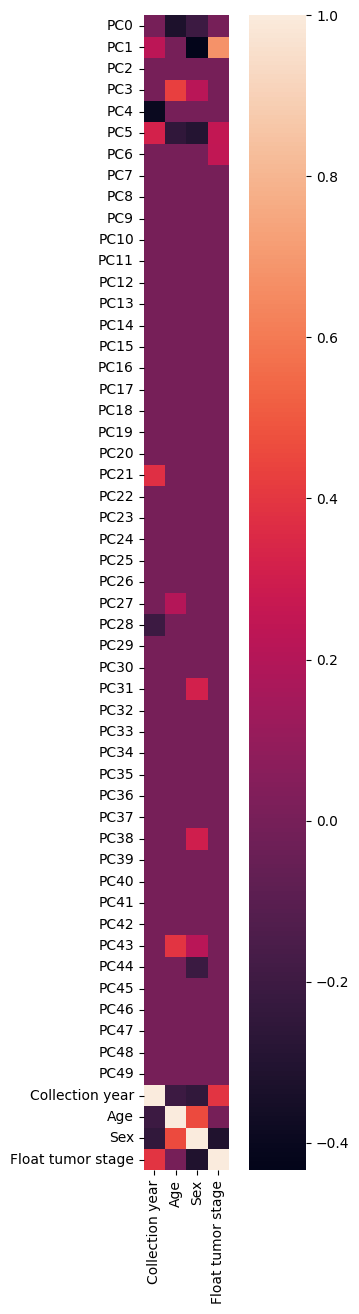

In [11]:
plt.figure(figsize=(5, 15))
corr = pca.corr()[:][50:].T
corr *= np.abs(corr) > 0.2
sns.heatmap(corr, square=True)

In [13]:
mel_features = features
p = PCA(50)
transf = p.fit_transform(mel_features)
pca = pd.DataFrame(transf)
pca.columns = [f"PC{c}" for c in pca.columns]

In [14]:
mel_data = data
mel_data = mel_data.dropna(subset=["Tumor stage"])

In [15]:
mel_data = mel_data.reset_index().drop("index", axis="columns")

In [16]:
mel_data['Sex'].replace({'f': -1, 'm': 1}, inplace=True)
mel_data['Group'].replace({'Nevus': -1, 'Melanoma': 1}, inplace=True)
mel_data['Ulcerated'].replace({False: -1, np.nan: 0, True: 1}, inplace=True)
mel_data['Secondary'].replace({False: -1, np.nan: 0, True: 1}, inplace=True)
mel_data['Nodular'].replace({False: -1, np.nan: 0, True: 1}, inplace=True)

repl = {ts : i for i, ts in enumerate(sorted(np.unique(mel_data['Tumor stage'].astype(str))))}
mel_data['Tumor stage'].replace(repl, inplace=True)

mel_data['Lymph nodes'] = mel_data['Lymph nodes'].apply(lambda x: x.split("N")[-1])
repl = {ln : i for i, ln in enumerate(sorted(np.unique(mel_data['Lymph nodes'].astype(str))))}
mel_data['Lymph nodes'].replace(repl, inplace=True)

mel_data['Distant metastases'] = mel_data['Distant metastases'].apply(lambda x: x.split("M")[-1])
repl = {dm : i for i, dm in enumerate(sorted(np.unique(mel_data['Distant metastases'].astype(str))))}
mel_data['Distant metastases'].replace(repl, inplace=True)

repl = {'IA': '1a', 'IB': '1b', 'IIA': '2a', 'IIB': '2b', 'IIC':'2c', 'IIIB': '3b', 'IIIC': '3c', 'IV M1c': "4M1c", 'IV, M1d': "4M1d"}
mel_data['Stage AJCC'].replace(repl, inplace=True)
repl = {st : i for i, st in enumerate(sorted(np.unique(mel_data['Stage AJCC'].astype(str))))}
mel_data['Stage AJCC'].replace(repl, inplace=True)

for c in ["Collection year", "Age", 'Sex', 'Ulcerated', 'Secondary', 'Nodular', 'Tumor stage', 'Lymph nodes', 'Distant metastases', 'Stage AJCC']: #cols:
    mel_data[c] = mel_data[c].astype(float)
    if mel_data[c].std() == 0:
        print(c)
    pca[c] = (mel_data[c] - mel_data[c].mean()) / (mel_data[c].std())

<Axes: >

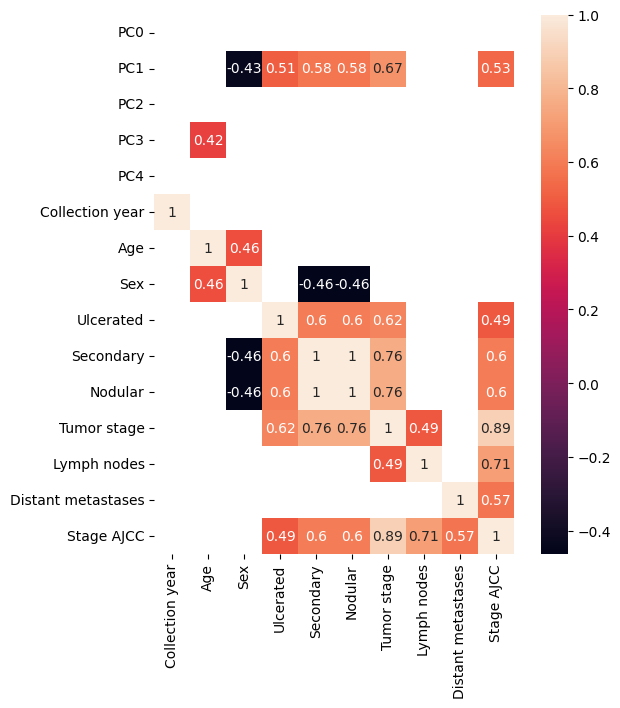

In [25]:
plt.figure(figsize=(7, 7))
corr = pca.corr()[:][50:].T
corr *= np.abs(corr) > 0.4
corr.drop([f"PC{i}" for i in range(5, 50)], axis=0, inplace=True)
sns.heatmap(corr, square=True, annot=True, mask=corr==0)